In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import probabilistic_hough_line
from skimage.draw import line
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

In [25]:
easy_data=pd.read_parquet('Data Science Intern - LiDAR Technical Test/lidar_cable_points_extrahard.parquet')

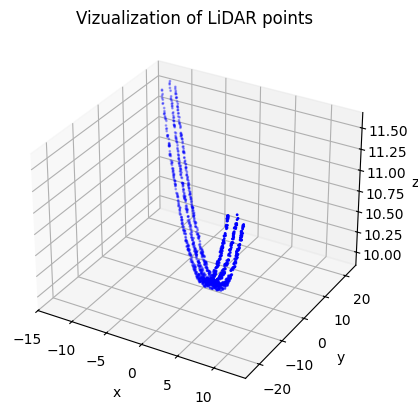

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(easy_data['x'], easy_data['y'], easy_data['z'], s=1, c='blue')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.title("Vizualization of LiDAR points")
plt.show()


/var/folders/1w/qdnlgvv57jsctw3wf6pt0wlr0000gn/T/ipykernel_9014/3508095418.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


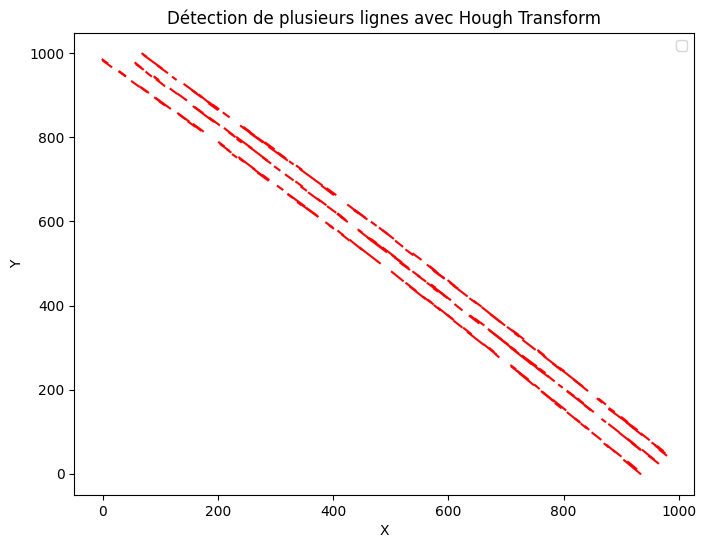

In [ ]:
points_xy = easy_data[['x', 'y']].values


img_size = (1000, 1000)

# Take the extremes of the points to normalize the coordinates
x_min, x_max = points_xy[:, 0].min(), points_xy[:, 0].max()
y_min, y_max = points_xy[:, 1].min(), points_xy[:, 1].max()

# Normalization
x_normalized = np.clip((points_xy[:, 0] - x_min) / (x_max - x_min) * (img_size[1] - 1), 0, img_size[1] - 1)
y_normalized = np.clip((points_xy[:, 1] - y_min) / (y_max - y_min) * (img_size[0] - 1), 0, img_size[0] - 1)

# Create a binary image
edges = np.zeros(img_size, dtype=np.uint8)
edges[y_normalized.astype(int), x_normalized.astype(int)] = 1

# Hough Transform
lines = probabilistic_hough_line(edges, threshold=10, line_length=5, line_gap=10)

plt.figure(figsize=(8, 6))
for line in lines:
    p0, p1 = line
    plt.plot([p0[0], p1[0]], [p0[1], p1[1]], color='red')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Hough Transform, lines detected')
plt.legend()
plt.show()



In [ ]:
def calculate_slope_intercept(p0, p1):
    x0, y0 = p0
    x1, y1 = p1
    m = (y1 - y0) / (x1 - x0)
    b = y0 - m * x0
    return m, b

In [ ]:


# Compute the slope and intercept for each line
slopes = []
intercepts = []
for p0, p1 in lines:
    m, b = calculate_slope_intercept(p0, p1)
    slopes.append(m)
    intercepts.append(b)

# stacking slopes and intercepts to create a feature matrix
slopes = np.array(slopes)
intercepts = np.array(intercepts)
features = np.vstack((slopes, intercepts)).T

# KMeans to cluster the lines
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(features)
labels = kmeans.labels_

# Fo each cluster, take the average slope and intercept
equations = []
for label in set(labels):
    cluster_indices = np.where(labels == label)[0]
    
    cluster_slopes = slopes[cluster_indices]
    cluster_intercepts = intercepts[cluster_indices]
    
    avg_slope = np.mean(cluster_slopes)
    avg_intercept = np.mean(cluster_intercepts)
    equations.append((avg_slope, avg_intercept))
    
    print(f"Cluster {label + 1}: y = {avg_slope:.2f}x + {avg_intercept:.2f}")


Cluster 1: y = -1.04x + 1053.62
Cluster 2: y = -1.01x + 1000.46
Cluster 3: y = -1.11x + 1115.14


Cluster 1: y = -1.82x + 0.43
Cluster 2: y = -1.77x + -1.27
Cluster 3: y = -1.93x + 1.62


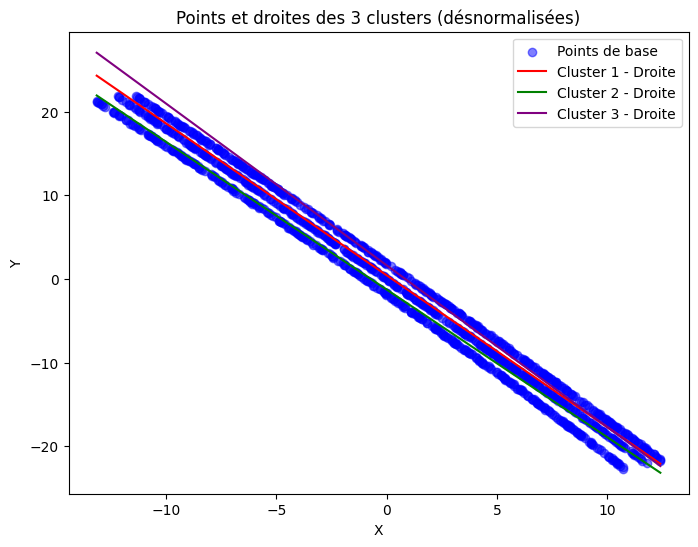

In [ ]:
# Denormalization function
def denormalize_slope_intercept(slope_norm, intercept_norm, x_min, x_max, y_min, y_max):
    scale_x = x_max - x_min
    scale_y = y_max - y_min
    
    slope_denorm = slope_norm * scale_y / scale_x
    intercept_denorm = intercept_norm * scale_y/img_size[0] - slope_denorm * x_min +y_min
    
    return slope_denorm, intercept_denorm


# Denormalization of slopes and intercepts
denormalized_equations = []
for label in set(labels):
    avg_slope, avg_intercept = equations[label]
    denormalized_slope, denormalized_intercept = denormalize_slope_intercept(avg_slope, avg_intercept, x_min, x_max, y_min, y_max)
    
    denormalized_equations.append((denormalized_slope, denormalized_intercept))
    
    print(f"Cluster {label + 1}: y = {denormalized_slope:.2f}x + {denormalized_intercept:.2f}")

plt.figure(figsize=(8, 6))
plt.scatter(points_xy[:, 0], points_xy[:, 1], c='blue', alpha=0.5, label='data points')
x_values = np.linspace(easy_data['x'].min(), easy_data['x'].max(), 100)
colors = ['red', 'green', 'purple']

for label in set(labels):
    denormalized_slope, denormalized_intercept = denormalized_equations[label]
    y_values = denormalized_slope * x_values + denormalized_intercept
    plt.plot(x_values, y_values, color=colors[label], label=f'Cluster {label + 1} - Line')


plt.xlabel('X')
plt.ylabel('Y')
plt.title('Points and predicted lines')
plt.legend()
plt.show()



In [ ]:
from sklearn.decomposition import PCA

def get_plane_pca(points):
    pca = PCA(n_components=2)
    transformed = pca.fit_transform(points)
    return transformed, pca


In [ ]:
from scipy.optimize import curve_fit
import numpy as np

def catenary(x, y0, c, x0):
    return y0 + c * (np.cosh((x - x0) / c) - 1)

params, _ = curve_fit(catenary, x_2D, y_2D, p0=[np.min(y_2D), 1, np.mean(x_2D)])


In [ ]:
# X_new_2D = np.column_stack((x_2D, catenary(x_2D, *params)))
X_cat_3D = pca.inverse_transform(X_new_2D)
